In [1]:
import json
import numpy as np
import random
import sys
from tqdm import tqdm
import re
from pathlib import Path

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer

from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
nlp = en_core_web_sm.load()

from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
from utils import get_triplets_by_idd, get_description_name
from datasets import load_rubq, load_simple_questions, combined_dataset
from models import EncoderBERT, get_projection_module_simple, get_tokenizer
from reject import reject_by_metric
from train import train_ensemble
from eval_models import eval_single_model

%load_ext autoreload
%autoreload 1

2022-08-18 11:05:01.865412: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-18 11:05:01.869996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-18 11:05:01.870018: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(m

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


### Loading Graph Embeddings and Questions

In [3]:
#path to full list of embeddings and full list of ids (one2one correspondence with embeddings)
PATH_TO_EMBEDDINGS_Q = "../new_data/entitie_embeddings_ru.json" 
PATH_TO_IDS = "../new_data/entitie_ids_ru_filtered.json"
PATH_TO_EMBEDDINGS_P = "../new_data/entitie_P_embeddings_ru.json" 

graph_embeddings_Q = json.load(open(PATH_TO_EMBEDDINGS_Q))
graph_embeddings_P = json.load(open(PATH_TO_EMBEDDINGS_P))

In [4]:
%autoreload

MASTER_SEED = 42

questions_train, relations_train, entities_train, answers_train, questions_val, relations_val, entities_val, answers_val, questions_test, answers_test = load_rubq(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)
simple_questions_train, simple_questions_val = load_simple_questions(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)

/notebook/meker/KBQA/datasets.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_train = np.array(answers)[train_ids]
/notebook/meker/KBQA/datasets.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_val = np.array(answers)[val_ids]


308
296
1186
16414


100% 16414/16414 [00:00<00:00, 188891.56it/s]

8327


### Dataset and Dataloaders

In [5]:
%autoreload

train_dataset = combined_dataset(questions_train, answers_train, entities_train, relations_train, graph_embeddings_Q, graph_embeddings_P, simple_questions_train, device)
val_dataset = combined_dataset(questions_val, answers_val, entities_val, relations_val, graph_embeddings_Q, graph_embeddings_P, simple_questions_val, device)

val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=64, shuffle=False)

### Training loop

In [6]:
loss = nn.MSELoss()
loss_name = str(loss)[:-2]
proj_hidden_size = 512
    
models_path = Path(f'./models/{loss_name}_{proj_hidden_size}_full_stochastic_rubq/')
models_path.mkdir(parents=True, exist_ok=True)

### Load pretrained model

In [7]:
%autoreload

proj_hidden_size = 512

encoder = EncoderBERT(device)
projection_E = get_projection_module_simple(device, proj_hidden_size)
projection_Q = get_projection_module_simple(device, proj_hidden_size)
projection_P = get_projection_module_simple(device, proj_hidden_size)

encoder.load_state_dict(torch.load(models_path / f'encoder_0_30.pt'))
projection_E.load_state_dict(torch.load(models_path / f'projection_E_0_30.pt'))
projection_Q.load_state_dict(torch.load(models_path / f'projection_Q_0_30.pt'))
projection_P.load_state_dict(torch.load(models_path / f'projection_P_0_30.pt'))

model = {'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E}

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Eval

### RuBQ

In [8]:
embeddings_Q = graph_embeddings_Q
ids_list = list(graph_embeddings_Q.keys())
embeddings_Q = [embeddings_Q[Q] for Q in ids_list]
embeddings_tensor_Q = torch.FloatTensor(embeddings_Q)

embeddings_P = graph_embeddings_P
embeddings_P = [embeddings_P[P] for P in graph_embeddings_P.keys()]
embeddings_tensor_P = torch.FloatTensor(embeddings_P)

In [9]:
candidates = list(np.load("./data/presearched_fixed_rubq_test.npy", allow_pickle=True))

In [10]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, entropies, acc, bad_question_ids = eval_single_model(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, model, device)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct

Accuracy:  0.484822934232715


In [11]:
mask = np.full_like(a_predicts, True)
mask[bad_question_ids] = False
mask = mask.astype(bool)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Now with score-based rejection

In [12]:
from reject import reject_by_metric

%autoreload

recalls = np.flip(np.linspace(0.01, 1.0, 100))
rubq_score_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(top1_scores)[mask], recalls, reverse_order=True)

table_recalls = np.array((0.6, 0.4, 0.2))
table_rubq_score_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(top1_scores)[mask], table_recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


### Now with delta-based rejection

In [13]:
top1_scores = np.array(top1_scores)
top2_scores = np.array(top2_scores)
delta = top1_scores - top2_scores

recalls = np.flip(np.linspace(0.01, 1.0, 100))
rubq_delta_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(delta)[mask], recalls, reverse_order=True)

table_recalls = np.array((0.6, 0.4, 0.2))
table_rubq_delta_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(delta)[mask], table_recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


### DDU

In [14]:
from ddu import variational_gmm_fit, gmm_evaluate_embeddings

embeddings_e = []
embeddings_q = []
embeddings_p = []

tokenizer = get_tokenizer()
MAX_LEN_Q = 32

for q, a in zip(questions_train, answers_train):    
    encoder = model['encoder']
    projection_E = model['projection_E']
    projection_P = model['projection_P']
    projection_Q = model['projection_Q']

    projection_E.eval()
    projection_P.eval()
    projection_Q.eval()
    X = torch.tensor([tokenizer.encode(q, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0].to(device)

    encoded_X = encoder(X[None,:])
    y_pred_e = projection_E(encoded_X).detach().cpu()
    y_pred_q = projection_Q(encoded_X).detach().cpu()
    y_pred_p = projection_P(encoded_X).detach().cpu()

    embeddings_e.append(y_pred_e.numpy())
    embeddings_q.append(y_pred_q.numpy())
    embeddings_p.append(y_pred_p.numpy())
    
embeddings_e = np.array(embeddings_e).squeeze()
embeddings_q = np.array(embeddings_q).squeeze()
embeddings_p = np.array(embeddings_p).squeeze()

rubq_gmm_e = variational_gmm_fit(embeddings_e, 100, 42)
rubq_gmm_q = variational_gmm_fit(embeddings_q, 100, 42)
rubq_gmm_p = variational_gmm_fit(embeddings_p, 100, 42)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct from a tensor, it

In [15]:
from ddu import variational_gmm_fit, variational_gmm_evaluate_embeddings

embeddings_e = []
embeddings_q = []
embeddings_p = []

for q, a in zip(questions_test, answers_test):    
    encoder = model['encoder']
    projection_E = model['projection_E']
    projection_P = model['projection_P']
    projection_Q = model['projection_Q']

    projection_E.eval()
    projection_P.eval()
    projection_Q.eval()
    X = torch.tensor([tokenizer.encode(q, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0].to(device)

    encoded_X = encoder(X[None,:])
    y_pred_e = projection_E(encoded_X).detach().cpu()
    y_pred_q = projection_Q(encoded_X).detach().cpu()
    y_pred_p = projection_P(encoded_X).detach().cpu()

    embeddings_e.append(y_pred_e.numpy())
    embeddings_q.append(y_pred_q.numpy())
    embeddings_p.append(y_pred_p.numpy())
    
embeddings_e = np.array(embeddings_e).squeeze()
embeddings_q = np.array(embeddings_q).squeeze()
embeddings_p = np.array(embeddings_p).squeeze()

rubq_gmm_e_logp = variational_gmm_evaluate_embeddings(rubq_gmm_e, embeddings_e)
rubq_gmm_q_logp = variational_gmm_evaluate_embeddings(rubq_gmm_q, embeddings_q)
rubq_gmm_p_logp = variational_gmm_evaluate_embeddings(rubq_gmm_p, embeddings_p)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_ids = torch.tensor(questions_ids)


In [16]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_e_gmm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(rubq_gmm_e_logp)[mask], recalls, reverse_order=True)
rubq_p_gmm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(rubq_gmm_p_logp)[mask], recalls, reverse_order=True)
rubq_q_gmm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(rubq_gmm_q_logp)[mask], recalls, reverse_order=True)

table_recalls = np.array((0.6, 0.4, 0.2))
table_rubq_e_gmm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(rubq_gmm_e_logp)[mask], table_recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

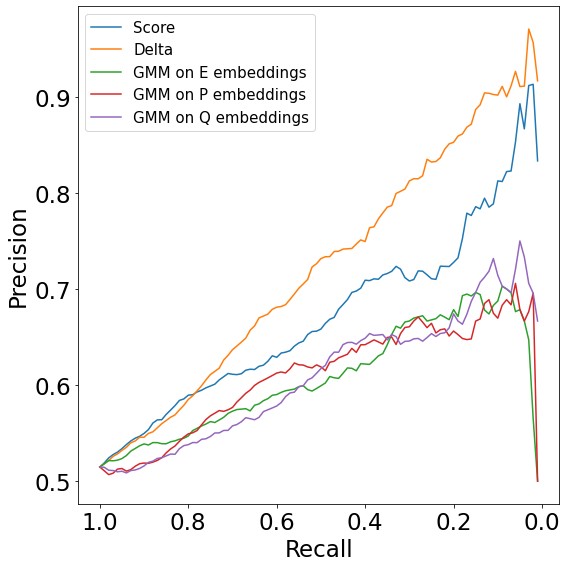

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_gmm_accs, label='GMM on E embeddings')
ax.plot(recalls, rubq_p_gmm_accs, label='GMM on P embeddings')
ax.plot(recalls, rubq_q_gmm_accs, label='GMM on Q embeddings')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

### Entropy and MI

In [18]:
%autoreload

recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


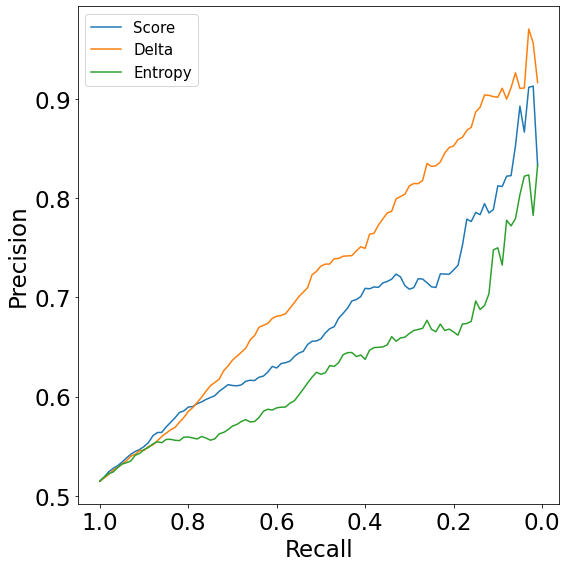

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 10 predictions

In [20]:
%autoreload

_, _, _, _, _, _, entropies, _, _ = eval_single_model(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, model, device, entropy_limit=10)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct

Accuracy:  0.484822934232715


In [21]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_e_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


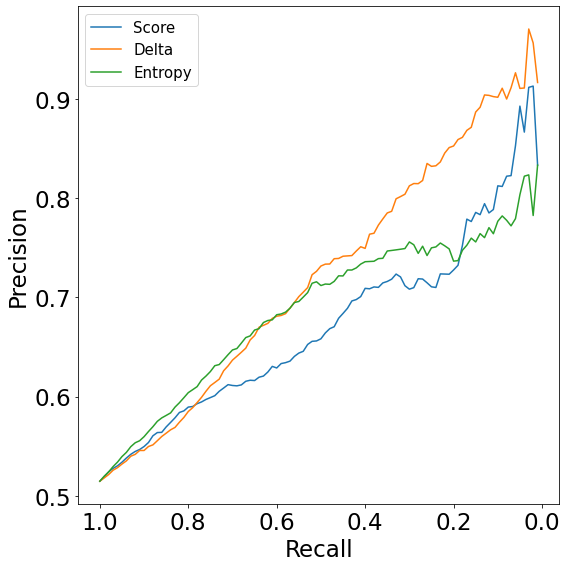

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs_10, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 8 predictions

In [23]:
%autoreload

_, _, _, _, _, _, entropies, _, _ = eval_single_model(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, model, device, entropy_limit=8)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [00:13, 86.33it/s]

Accuracy:  0.484822934232715


In [24]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_e_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


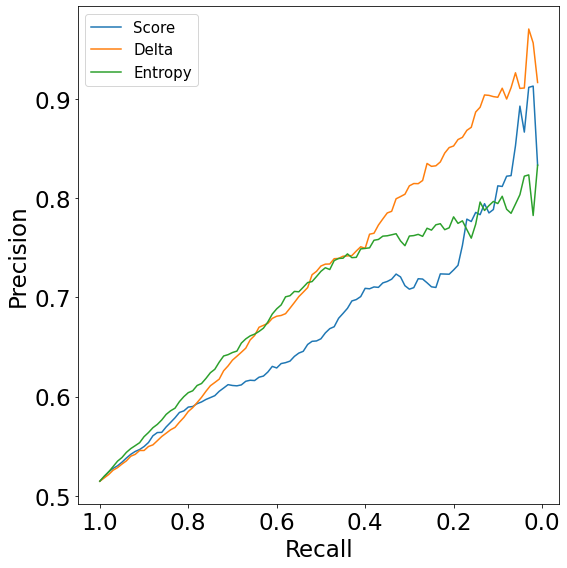

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs_8, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 5 predictions

In [26]:
%autoreload

_, _, _, _, _, _, entropies, _, _ = eval_single_model(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, model, device, entropy_limit=5)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [00:13, 88.27it/s] 

Accuracy:  0.484822934232715


In [27]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_e_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


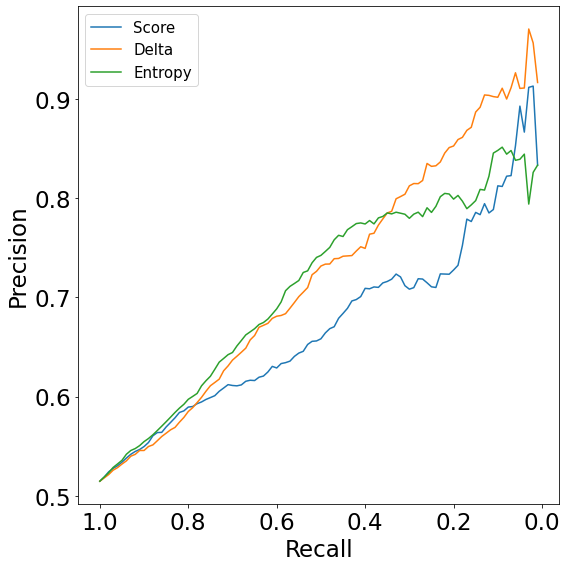

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs_5, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 3 predictions

In [29]:
%autoreload

_, _, _, _, _, _, entropies, _, _ = eval_single_model(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, model, device, entropy_limit=3)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [00:13, 85.57it/s]

Accuracy:  0.484822934232715


In [30]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_e_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies)[mask], recalls)

table_recalls = np.array((0.6, 0.4, 0.2))
table_rubq_e_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies)[mask], table_recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


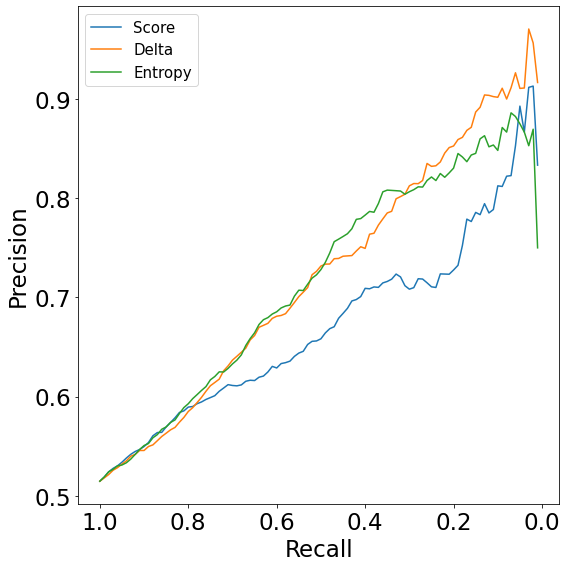

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs_3, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

### Simple Questions

In [32]:
import pickle

entities = np.load('data/candidate_entities_sq_test.npy', allow_pickle=True)

with open('data/entity_subgraphs_sq_test.pickle', 'rb') as handle:
    entity_subgraphs = pickle.load(handle)

In [33]:
sq_candidates = []

for question_entities in entities:
    candidates_dict = {}
    for entity in list(question_entities.item()):
        candidates_dict[entity] = entity_subgraphs[entity]
    sq_candidates.append(candidates_dict)

In [34]:
simple_questions_test = np.load("../new_data/simple_questions_test.npy")

simple_questions_filtered = []
questions_sq = []
answers_sq = []

for e, p, a, q in tqdm(simple_questions_test):
    if e in graph_embeddings_Q and a in graph_embeddings_Q and p in graph_embeddings_P:
        simple_questions_filtered.append((e, p, a, q))
        questions_sq.append(q)
        answers_sq.append([a])

100% 4751/4751 [00:00<00:00, 191690.04it/s]


In [35]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, entropies, acc, bad_question_ids = eval_single_model(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, model, device)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [00:30, 80.13it/s]

Accuracy:  0.5233798195242002


In [36]:
mask = np.full_like(a_predicts, True)
mask[bad_question_ids] = False
mask = mask.astype(bool)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Now with score-based rejection

In [37]:
from reject import reject_by_metric

%autoreload

recalls = np.flip(np.linspace(0.01, 1.0, 100))
sq_score_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(top1_scores)[mask], recalls, reverse_order=True)


table_recalls = np.array((0.6, 0.4, 0.2))
table_sq_score_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(top1_scores)[mask], table_recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


### Now with delta-based rejection

In [38]:
top1_scores = np.array(top1_scores)
top2_scores = np.array(top2_scores)
delta = top1_scores - top2_scores

recalls = np.flip(np.linspace(0.01, 1.0, 100))
sq_delta_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(delta)[mask], recalls, reverse_order=True)

table_recalls = np.array((0.6, 0.4, 0.2))
table_sq_delta_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(delta)[mask], table_recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


### DDU

In [39]:
from ddu import variational_gmm_fit, gmm_evaluate_embeddings

embeddings_e = []
embeddings_q = []
embeddings_p = []

tokenizer = get_tokenizer()
MAX_LEN_Q = 32

for _, _, q, a in simple_questions_train:  
    encoder = model['encoder']
    projection_E = model['projection_E']
    projection_P = model['projection_P']
    projection_Q = model['projection_Q']

    projection_E.eval()
    projection_P.eval()
    projection_Q.eval()
    X = torch.tensor([tokenizer.encode(q, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0].to(device)

    encoded_X = encoder(X[None,:])
    y_pred_e = projection_E(encoded_X).detach().cpu()
    y_pred_q = projection_Q(encoded_X).detach().cpu()
    y_pred_p = projection_P(encoded_X).detach().cpu()

    embeddings_e.append(y_pred_e.numpy())
    embeddings_q.append(y_pred_q.numpy())
    embeddings_p.append(y_pred_p.numpy())
    
embeddings_e = np.array(embeddings_e).squeeze()
embeddings_q = np.array(embeddings_q).squeeze()
embeddings_p = np.array(embeddings_p).squeeze()

sq_gmm_e = variational_gmm_fit(embeddings_e, 100, 42)
sq_gmm_q = variational_gmm_fit(embeddings_q, 100, 42)
sq_gmm_p = variational_gmm_fit(embeddings_p, 100, 42)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [40]:
from ddu import variational_gmm_fit, variational_gmm_evaluate_embeddings

embeddings_e = []
embeddings_q = []
embeddings_p = []

for q, a in zip(questions_sq, answers_sq):    
    encoder = model['encoder']
    projection_E = model['projection_E']
    projection_P = model['projection_P']
    projection_Q = model['projection_Q']

    projection_E.eval()
    projection_P.eval()
    projection_Q.eval()
    X = torch.tensor([tokenizer.encode(q, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0].to(device)

    encoded_X = encoder(X[None,:])
    y_pred_e = projection_E(encoded_X).detach().cpu()
    y_pred_q = projection_Q(encoded_X).detach().cpu()
    y_pred_p = projection_P(encoded_X).detach().cpu()

    embeddings_e.append(y_pred_e.numpy())
    embeddings_q.append(y_pred_q.numpy())
    embeddings_p.append(y_pred_p.numpy())
    
embeddings_e = np.array(embeddings_e).squeeze()
embeddings_q = np.array(embeddings_q).squeeze()
embeddings_p = np.array(embeddings_p).squeeze()

sq_gmm_e_logp = variational_gmm_evaluate_embeddings(sq_gmm_e, embeddings_e)
sq_gmm_q_logp = variational_gmm_evaluate_embeddings(sq_gmm_q, embeddings_q)
sq_gmm_p_logp = variational_gmm_evaluate_embeddings(sq_gmm_p, embeddings_p)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_ids = torch.tensor(questions_ids)


In [41]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_e_gmm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(sq_gmm_e_logp)[mask], recalls, reverse_order=True)
sq_p_gmm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(sq_gmm_p_logp)[mask], recalls, reverse_order=True)
sq_q_gmm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(sq_gmm_q_logp)[mask], recalls, reverse_order=True)

table_recalls = np.array((0.6, 0.4, 0.2))
table_sq_e_gmm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(sq_gmm_e_logp)[mask], table_recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

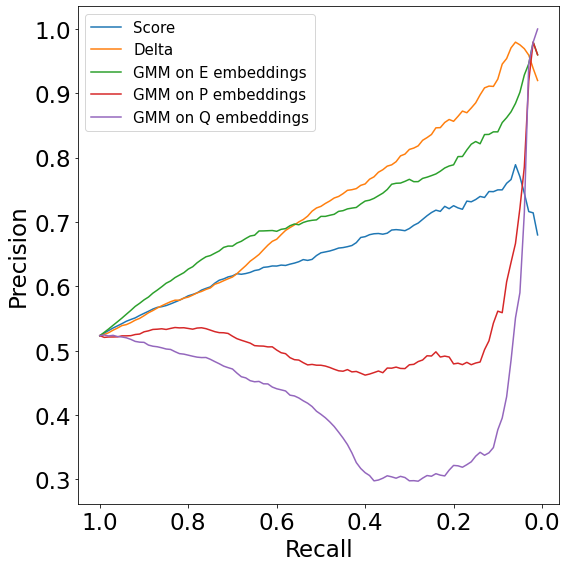

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_gmm_accs, label='GMM on E embeddings')
ax.plot(recalls, sq_p_gmm_accs, label='GMM on P embeddings')
ax.plot(recalls, sq_q_gmm_accs, label='GMM on Q embeddings')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

### Entropy and MI

In [43]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


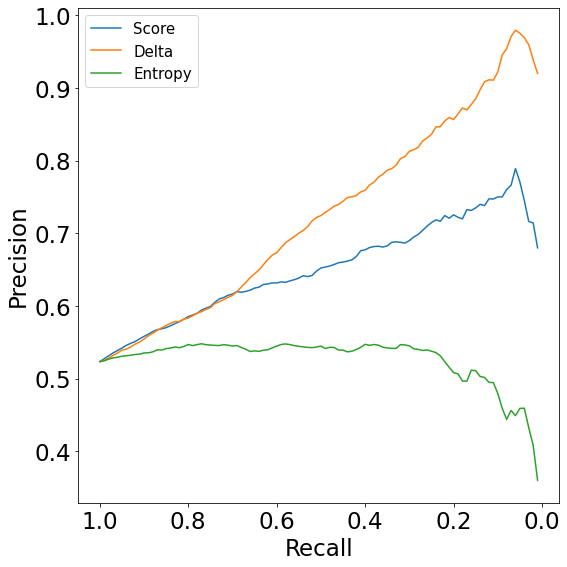

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 10 predictions

In [45]:
%autoreload

_, _, _, _, _, _, entropies, _, _ = eval_single_model(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, model, device, entropy_limit=10)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct

Accuracy:  0.5233798195242002


In [46]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_e_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


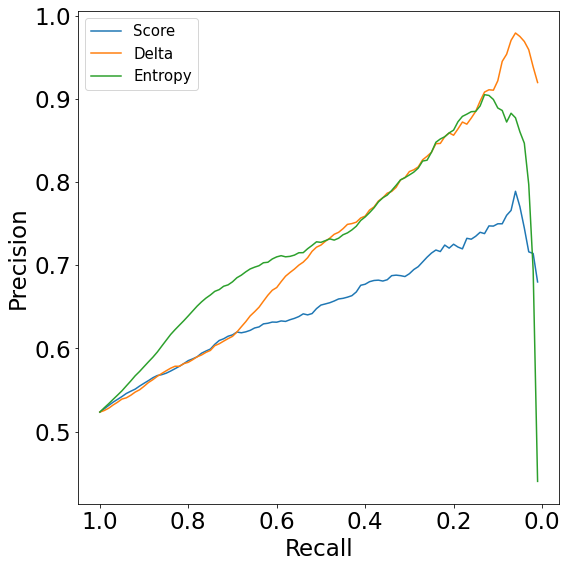

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs_10, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 8 predictions

In [48]:
%autoreload

_, _, _, _, _, _, entropies, _, _ = eval_single_model(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, model, device, entropy_limit=8)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [00:30, 79.50it/s]

Accuracy:  0.5233798195242002


In [49]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_e_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


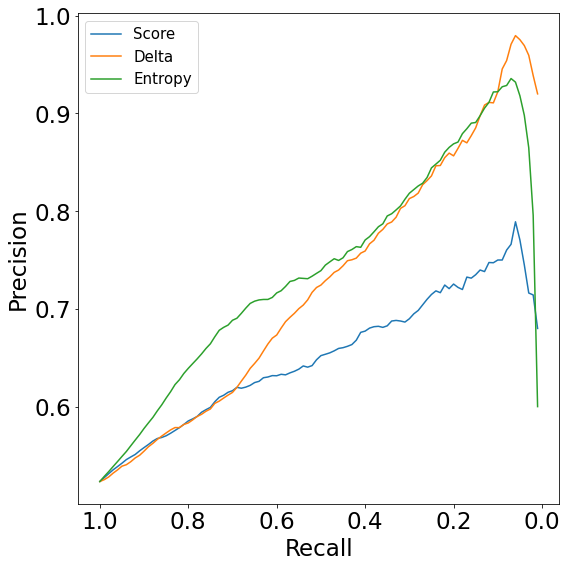

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs_8, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 5 predictions

In [51]:
%autoreload

_, _, _, _, _, _, entropies, _, _ = eval_single_model(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, model, device, entropy_limit=5)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [00:31, 78.50it/s]

Accuracy:  0.5233798195242002


In [52]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_e_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


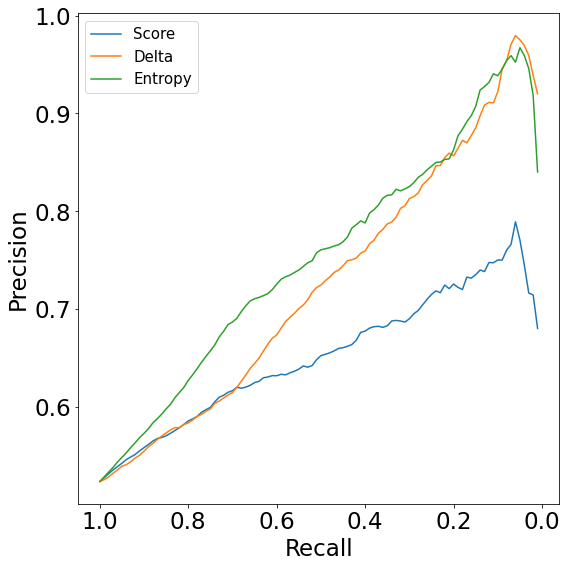

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs_5, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 3 predictions

In [54]:
%autoreload

_, _, _, _, _, _, entropies, _, _ = eval_single_model(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, model, device, entropy_limit=3)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [00:30, 79.64it/s]

Accuracy:  0.5233798195242002


In [55]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_e_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies)[mask], recalls)

table_recalls = np.array((0.6, 0.4, 0.2))
table_sq_e_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies)[mask], table_recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


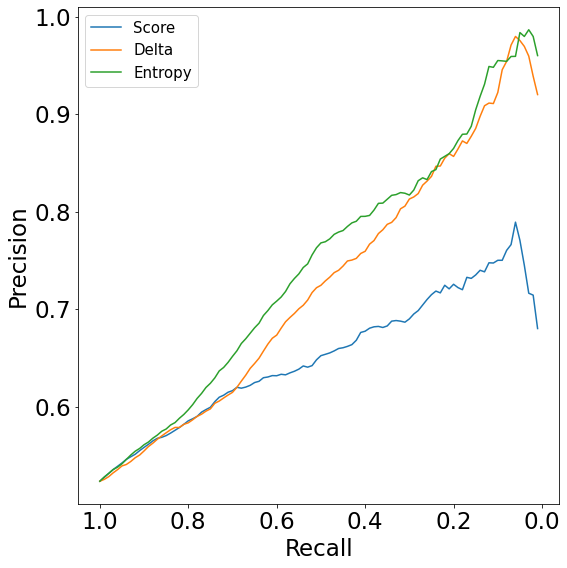

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs_3, label='Entropy')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [57]:
from sklearn.metrics import auc

rubq_rejected_accs = [
    rubq_score_accs,
    rubq_delta_accs,
    rubq_e_accs,
    rubq_e_accs_10,
    rubq_e_accs_8,
    rubq_e_accs_5,
    rubq_e_accs_3,
    rubq_e_gmm_accs
]

rubq_rejected_acc_names = [
    'rubq_score_accs',
    'rubq_delta_accs',
    'rubq_e_accs',
    'rubq_e_accs_10',
    'rubq_e_accs_8',
    'rubq_e_accs_5',
    'rubq_e_accs_3',
    'rubq_e_gmm_accs'
]

rubq_aucs = []
for acc_ary in rubq_rejected_accs:
    rubq_aucs.append(auc(recalls, acc_ary))
    
sorting = np.flip(np.argsort(rubq_aucs))

sorted_aucs = np.array(rubq_aucs)[sorting]
sorted_names = np.array(rubq_rejected_acc_names)[sorting]

for rej_auc, name in zip(sorted_aucs, sorted_names):
    print(name, rej_auc)

rubq_delta_accs 0.7137392808189652
rubq_e_accs_3 0.7088407507044867
rubq_e_accs_5 0.7016708572821833
rubq_e_accs_8 0.6883629424754645
rubq_e_accs_10 0.6796417416197651
rubq_score_accs 0.6628600181307863
rubq_e_accs 0.6188228808842413
rubq_e_gmm_accs 0.6007990956864115


In [58]:
from sklearn.metrics import auc

sq_rejected_accs = [
    sq_score_accs,
    sq_delta_accs,
    sq_e_accs,
    sq_e_accs_10,
    sq_e_accs_8,
    sq_e_accs_5,
    sq_e_accs_3,
    sq_e_gmm_accs
]

sq_rejected_acc_names = [
    'sq_score_accs',
    'sq_delta_accs',
    'sq_e_accs',
    'sq_e_accs_10',
    'sq_e_accs_8',
    'sq_e_accs_5',
    'sq_e_accs_3',
    'sq_e_gmm_accs'
]

sq_aucs = []
for acc_ary in sq_rejected_accs:
    sq_aucs.append(auc(recalls, acc_ary))
    
sorting = np.flip(np.argsort(sq_aucs))

sorted_aucs = np.array(sq_aucs)[sorting]
sorted_names = np.array(sq_rejected_acc_names)[sorting]

for rej_auc, name in zip(sorted_aucs, sorted_names):
    print(name, rej_auc)

sq_e_accs_5 0.7439901817024195
sq_e_accs_3 0.7374955798419249
sq_e_accs_8 0.7337088232228729
sq_e_accs_10 0.7222367757082706
sq_delta_accs 0.71698193635729
sq_e_gmm_accs 0.7053642064189356
sq_score_accs 0.6441974704533133
sq_e_accs 0.5220540072548965


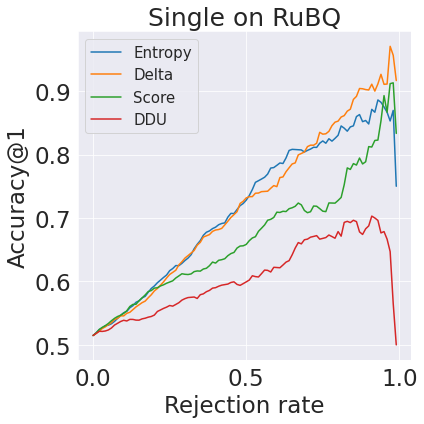

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style('darkgrid')

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('Single on RuBQ', fontsize=25)
ax.plot(1 - recalls, rubq_e_accs_3, label='Entropy')
ax.plot(1 - recalls, rubq_delta_accs, label='Delta')
ax.plot(1 - recalls, rubq_score_accs, label='Score')
ax.plot(1 - recalls, rubq_e_gmm_accs, label='DDU')
# ax.invert_xaxis()
ax.set_xlabel('Rejection rate', fontsize=23)
ax.set_ylabel('Accuracy@1', fontsize=23)
ax.legend()
plt.tight_layout()
plt.savefig('figs/single_rubq.pdf')

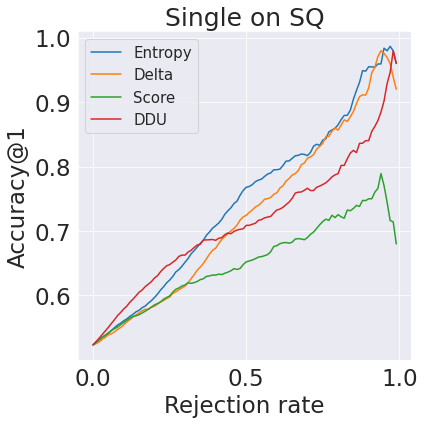

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('Single on SQ', fontsize=25)
ax.plot(1 - recalls, sq_e_accs_3, label='Entropy')
ax.plot(1 - recalls, sq_delta_accs, label='Delta')
ax.plot(1 - recalls, sq_score_accs, label='Score')
ax.plot(1 - recalls, sq_e_gmm_accs, label='DDU')
# ax.invert_xaxis()
ax.set_xlabel('Rejection rate', fontsize=23)
ax.set_ylabel('Accuracy@1', fontsize=23)
ax.legend()
plt.tight_layout()
plt.savefig('figs/single_sq.pdf')

In [61]:
recalls_table = (0.2, 0.4, 0.6)

header="""
\\begin{table*}[h]
\\fontsize{10.0pt}{10.0pt}\selectfont
\\centering % used for centering table
\\begin{tabular}{|c | c c c | c c c |}
\\toprule
UE approach & RuBQ@0.2 & RuBQ@0.4 & RuBQ@0.6 & SQ@0.2 & SQ@0.4 & SQ@0.6\\ % inserts table
\\midrule
"""

row_names = ['Single Entropy', 'Single Delta', 'Single Score', 'Single DDU']
rubq_results = [table_rubq_e_accs_3, table_rubq_delta_accs, table_rubq_score_accs, table_rubq_e_gmm_accs]
sq_results = [table_sq_e_accs_3, table_sq_delta_accs, table_sq_score_accs, table_sq_e_gmm_accs]

body = ""

for name, rubq_result, sq_result in zip(row_names, rubq_results, sq_results):
    rubq_result_2 = rubq_result[0]
    rubq_result_4 = rubq_result[1]
    rubq_result_6 = rubq_result[2]
    sq_result_2 = sq_result[0]
    sq_result_4 = sq_result[1]
    sq_result_6 = sq_result[2]
    body += f"{name} & {round(rubq_result_2, 2)} & {round(rubq_result_4, 2)} & {round(rubq_result_6, 2)} & {round(sq_result_2, 2)} & {round(sq_result_4, 2)} & {round(sq_result_6, 2)}\\\\\n"
    
footer="""
\\bottomrule
\\end{tabular}
\\caption{Comparison with existing solutions (DP, QA-Ru, QA-En, SimBa). Accuracy on RuBQ 2.0 test set for different types of questions. Mean and std on 5 restarts with different random seeds. Ours-Ru -- testing on Russian language questions; Ours-En -- testing on machine-translated to English language questions. The model with the best score is highlighted in bold font.} % title of 
\\label{table:results} % is used to refer this table in the text
\\end{table*}
"""

print(header+body+footer)


\begin{table*}[h]
\fontsize{10.0pt}{10.0pt}\selectfont
\centering % used for centering table
\begin{tabular}{|c | c c c | c c c |}
\toprule
UE approach & RuBQ@0.2 & RuBQ@0.4 & RuBQ@0.6 & SQ@0.2 & SQ@0.4 & SQ@0.6\ % inserts table
\midrule
Single Entropy & 0.69 & 0.78 & 0.83 & 0.71 & 0.8 & 0.86\\
Single Delta & 0.68 & 0.75 & 0.85 & 0.67 & 0.76 & 0.86\\
Single Score & 0.63 & 0.71 & 0.73 & 0.63 & 0.68 & 0.73\\
Single DDU & 0.59 & 0.62 & 0.68 & 0.69 & 0.73 & 0.79\\

\bottomrule
\end{tabular}
\caption{Comparison with existing solutions (DP, QA-Ru, QA-En, SimBa). Accuracy on RuBQ 2.0 test set for different types of questions. Mean and std on 5 restarts with different random seeds. Ours-Ru -- testing on Russian language questions; Ours-En -- testing on machine-translated to English language questions. The model with the best score is highlighted in bold font.} % title of 
\label{table:results} % is used to refer this table in the text
\end{table*}



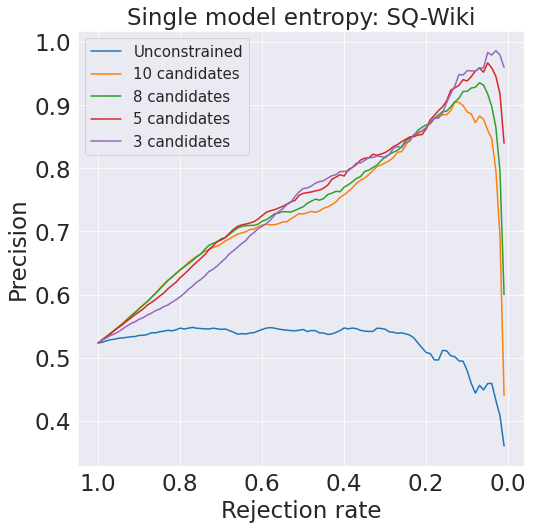

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style('darkgrid')

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('Single model entropy: SQ-Wiki', fontsize=23)
ax.plot(recalls, sq_e_accs, label='Unconstrained')
ax.plot(recalls, sq_e_accs_10, label='10 candidates')
ax.plot(recalls, sq_e_accs_8, label='8 candidates')
ax.plot(recalls, sq_e_accs_5, label='5 candidates')
ax.plot(recalls, sq_e_accs_3, label='3 candidates')
ax.invert_xaxis()
ax.set_xlabel('Rejection rate', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.savefig('figs/entropy_single_sq.pdf')

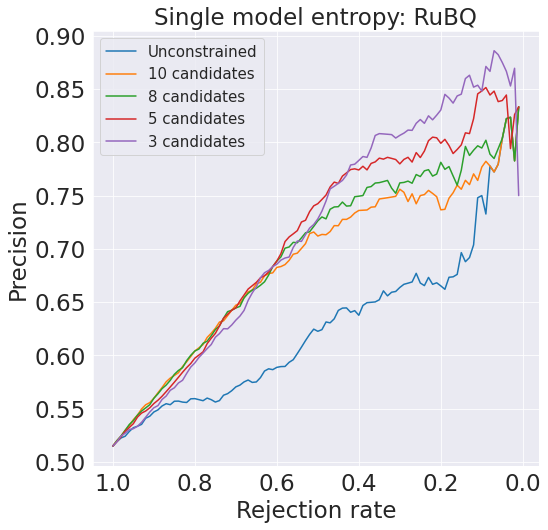

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style('darkgrid')

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('Single model entropy: RuBQ', fontsize=23)
ax.plot(recalls, rubq_e_accs, label='Unconstrained')
ax.plot(recalls, rubq_e_accs_10, label='10 candidates')
ax.plot(recalls, rubq_e_accs_8, label='8 candidates')
ax.plot(recalls, rubq_e_accs_5, label='5 candidates')
ax.plot(recalls, rubq_e_accs_3, label='3 candidates')
ax.invert_xaxis()
ax.set_xlabel('Rejection rate', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.savefig('figs/entropy_single_rubq.pdf')

In [64]:
torch.cuda.empty_cache()